/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

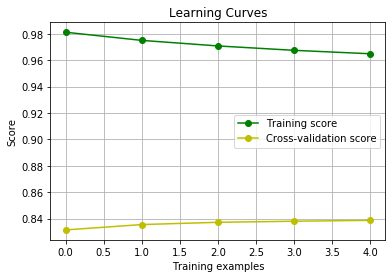

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier  # 随机森林
from sklearn.model_selection import GridSearchCV, train_test_split  # 网格评分器
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import make_scorer  # 创建评分
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer  # 文本编码

train_data = pd.read_csv('census.csv')  # 读取需要训练的数据
pred_data = pd.read_csv('test_census.csv')  # 读取需要预测的数据

train_data['income'] = np.where(train_data['income'] == '<=50K', 0, 1)  # 转换结果为 0, 1

y_len = train_data.shape[1]  # 特征数量

x = train_data.iloc[:, 0: y_len - 1]
y = train_data.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)  # 切割数据为训练集和测试集

# 需要过滤空格的特征
strip = ['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
         'native-country']

# 需要热编码的特征
one_hot_encoder = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# 需要label_encoder编码的特征
label_encoder = ['education_level']

hot_encoder_dict = dict()

for col in one_hot_encoder:

    if col == 'native-country':
        keys = ['United-States', 'Mexico', 'Other']
    else:
        train_data[col] = train_data[col].str.strip()  # 过滤空格
        value_counts = train_data[col].value_counts(normalize=True)  # 计算分类占比 (后续可以用于特征缩放)
        keys = list(value_counts.keys())

    hot_encoder_dict[col] = keys


def data_processing(df):
    """
    数据预处理
    :param df:
    :return:
    """

    for col in strip:
        df[col] = df[col].fillna('Other')
        df[col] = df[col].str.strip()

    # label_encoder 编码
    for col in label_encoder:
        df[col] = LabelEncoder().fit(df[col]).transform(df[col])

    for col in one_hot_encoder:
        if col == 'native-country':
            df[col] = df[col].where(df[col].isin(['United-States', 'Mexico']), 'Other')
        else:
            df[col] = df[col].where(df[col].isin(hot_encoder_dict[col]), 'Other')

        df[col] = df[col].astype(pd.CategoricalDtype(categories=hot_encoder_dict[col], ordered=True))

        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)

    df.drop(one_hot_encoder, axis=1, inplace=True)
    return df


def plot_learning_curve(X, y, estimator):
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=1,
                                                            train_sizes=np.linspace(.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")

    plt.legend(loc="best")

    plt.show()


x_train = data_processing(x_train)
x_test = data_processing(x_test)
pred_data = data_processing(pred_data)


plot_learning_curve(x_train, y_train, RandomForestClassifier())
# plot_learning_curve(x_train, y_train, GaussianNB())

# model = RandomForestClassifier()
# model.fit(x_train, y_train)
#
# y_pred = model.predict(x_test)
#
# acc = accuracy_score(y_test, y_pred)
# precision_score = precision_score(y_test, y_pred)
# recall_score = recall_score(y_test, y_pred)
# f1_score = f1_score(y_test, y_pred)
# roc_curve = roc_curve(y_test, y_pred)
#
# print('acc: ', acc)
# print('precision_score: ', precision_score)
# print('recall_score: ', recall_score)
# print('f1_score: ', f1_score)
# print('roc_curve: ', roc_curve)

# print(x_train.columns.values)
# print(x_test)
# print(pred_data)
